# Model


## Libaries

In [582]:

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
#Libaries for calculation and processing
from einops import rearrange, repeat
import math
from math import sqrt
from math import ceil
import numpy as np
from sklearn.preprocessing import StandardScaler
#libaries for data importng, formating and handling 
import pandas as pd
#For analysis and plotting
import matplotlib.pyplot as plt
import seaborn as sns
#others
import os
import time
import json
import pickle
import warnings
warnings.filterwarnings('ignore')


# Model architecture

## Embedding


In [583]:

class DSW_embedding(nn.Module):
    def __init__(self, seg_len, d_model):
        super(DSW_embedding, self).__init__()
        self.seg_len = seg_len

        self.linear = nn.Linear(seg_len, d_model)

    def forward(self, x):
        batch, ts_len, ts_dim = x.shape

        x_segment = rearrange(x, 'b (seg_num seg_len) d -> (b d seg_num) seg_len', seg_len = self.seg_len)
        x_embed = self.linear(x_segment)
        x_embed = rearrange(x_embed, '(b d seg_num) d_model -> b d seg_num d_model', b = batch, d = ts_dim)
        
        return x_embed

In [584]:



seg_len = 4  # Segment length
d_model = 256  # Dimension of the embedding space

# Initialize the embedding module
embedding_module = DSW_embedding(seg_len=seg_len, d_model=d_model)

x = torch.randn(1, 12, 2)  # Shape: [batch, ts_len, ts_dim]

# Apply the embedding
x_embedded = embedding_module(x)

# Show the embedded output
print(x_embedded.shape)
print(x_embedded)

torch.Size([1, 2, 3, 256])
tensor([[[[ 4.8974e-02, -1.4551e-01, -1.6245e-01,  ..., -7.1836e-02,
           -2.8191e-01,  1.4125e-01],
          [ 8.2272e-01,  1.6302e+00,  5.3047e-01,  ...,  1.0662e+00,
            9.4913e-01,  7.9408e-01],
          [ 3.3346e-01,  4.2382e-01,  8.0802e-01,  ...,  1.8310e-01,
           -3.1895e-02,  3.9826e-02]],

         [[-1.0839e-01, -1.0847e-01, -1.9807e-01,  ..., -8.5538e-01,
            5.4212e-02,  2.5536e-01],
          [ 6.9955e-01,  9.9412e-01,  8.7166e-01,  ...,  9.5344e-01,
           -1.4138e-03,  9.3820e-01],
          [ 4.0978e-01,  3.2011e-02,  7.9255e-01,  ...,  1.0655e+00,
           -7.4531e-01, -3.0191e-01]]]], grad_fn=<ViewBackward0>)


## AttentionLayer Inter feature



In [585]:

class FullAttention(nn.Module):
    '''
    The Attention operation
    '''
    def __init__(self, scale=None, attention_dropout=0.1,return_attention = False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.dropout = nn.Dropout(attention_dropout)
        self.return_attention = return_attention
        
    def forward(self, queries, keys, values):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)
        
        if self.return_attention:
            return V.contiguous(), A.contiguous()
        
        return V.contiguous()


In [586]:


class AttentionLayer(nn.Module):
    '''
    The Multi-head Self-Attention (MSA) Layer
    '''
    def __init__(self, d_model, n_heads, d_keys=None, d_values=None, dropout = 0.1,return_attention=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)
        
        self.return_attention = return_attention
        self.inner_attention = FullAttention(scale=None, attention_dropout = dropout,return_attention=self.return_attention)
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        if(self.return_attention):
            out,attention_weights= self.inner_attention(
                queries,
                keys,
                values,)

            out = out.view(B, L, -1)
        
            return self.out_projection(out), attention_weights
        
        else:
            out = self.inner_attention(
            queries,
            keys,
            values,)

            out = out.view(B, L, -1)
            return self.out_projection(out)
            
        


## TSA Cross-former

In [587]:
class TwoStageAttentionLayer(nn.Module):
    '''
    The Two Stage Attention (TSA) Layer
    input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
    '''
    def __init__(self, seg_num, factor, d_model, n_heads, d_ff = None, dropout=0.1):
        super(TwoStageAttentionLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.time_attention = AttentionLayer(d_model, n_heads, dropout = dropout,return_attention=False)
        self.dim_sender = AttentionLayer(d_model, n_heads, dropout = dropout,return_attention=True)
        self.dim_receiver = AttentionLayer(d_model, n_heads, dropout = dropout,return_attention=True)
        self.router = nn.Parameter(torch.randn(seg_num, factor, d_model))
        
        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
                                nn.GELU(),
                                nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
                                nn.GELU(),
                                nn.Linear(d_ff, d_model))
        
            
        self.attention_details = []

        
    
    def store_attn(self,receive_weights,send_weights):
        
        self.attention_details.append({
            'att-A-B': send_weights.detach(),  # Detach tensors for storage
            'att-B-A': receive_weights.detach(),
        })
    
    
    def get_attn(self):
        return self.attention_details
        
    def reset_attention_across_channels_details(self):
        self.attention_details = []
        
    def forward(self, x):
        #input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
        
        #Cross Time Stage: Directly apply MSA to each dimension
        batch = x.shape[0]
        ts_d = x.shape[1]
        time_in = rearrange(x, 'b ts_d seg_num d_model -> (b ts_d) seg_num d_model')
        time_enc = self.time_attention(
            time_in, time_in, time_in
        )
        dim_in = time_in + self.dropout(time_enc)
        dim_in = self.norm1(dim_in)
        dim_in = dim_in + self.dropout(self.MLP1(dim_in))
        dim_in = self.norm2(dim_in)
        
        final_out = rearrange(dim_in, '(b ts_d) seg_num d_model -> b ts_d seg_num d_model', b = batch,ts_d=ts_d)
   
        
        #Cross Dimension Stage: use a small set of learnable vectors to aggregate and distribute messages to build the D-to-D connection
        dim_send = rearrange(dim_in, '(b ts_d) seg_num d_model -> (b seg_num) ts_d d_model', b = batch)
        batch_router = repeat(self.router, 'seg_num factor d_model -> (repeat seg_num) factor d_model', repeat = batch)
        dim_buffer,send_weights = self.dim_sender(batch_router, dim_send, dim_send)
        dim_receive,receive_weights = self.dim_receiver(dim_send, dim_buffer, dim_buffer)
        
        
        dim_enc = dim_send + self.dropout(dim_receive)
        dim_enc = self.norm3(dim_enc)
        dim_enc = dim_enc + self.dropout(self.MLP2(dim_enc))
        dim_enc = self.norm4(dim_enc)
        
        final_out = rearrange(dim_enc, '(b seg_num) ts_d d_model -> b ts_d seg_num d_model', b = batch)
        
        
        self.store_attn(receive_weights,send_weights)
              
        return final_out

     


## AttentionLayer across Timeseries




In [588]:

class AttentionLayerCrossSegments(nn.Module):
    '''
    The Multi-head Self-Attention (MSA) Layer
    '''
    def __init__(self, d_model, n_heads, d_keys=None, d_values=None, dropout = 0.1,return_attention=True):
        super(AttentionLayerCrossSegments, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)
        
        self.return_attention = return_attention
        self.inner_attention1 = FullAttention(scale=None, attention_dropout = dropout,return_attention=self.return_attention)
        self.inner_attention2 = FullAttention(scale=None, attention_dropout = dropout,return_attention=self.return_attention)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out1_projection = nn.Linear(d_values * n_heads, d_model)
        self.out2_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
       
        

    def forward(self, queries, keys, values,num_patches):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        
     
        queries_projected = self.query_projection(queries).view(B, L, H, -1)
        keys_projected = self.key_projection(keys).view(B, S, H, -1)
        values_projected = self.value_projection(values).view(B, S, H, -1)
        
        """ queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)"""
        
        q = queries_projected[:, :num_patches, :, :]
        k = keys_projected[:, -num_patches:, :, :]
        v = values_projected[:, -num_patches:, :, :]
        
        L= q.shape[1]
        
        if(self.return_attention):
            
            out1,attention_weights1= self.inner_attention1(
                q,
                k,
                v,
                )
            
            
            
            out2,attention_weights2= self.inner_attention2(
                k,
                q,
                q,
                )

            out1 = out1.view(B, L, -1)
            out2 = out2.view(B, L, -1)
            concatenated = torch.cat([out1, out2], dim=1)
            
            
            return self.out1_projection(concatenated), attention_weights1, attention_weights2,
        
        
        else:
            
            out1 = self.inner_attention1(
                q,
                k,
                v,)
            
            out2,attention_weights2= self.inner_attention2(
                k,
                q,
                q,
                )
            out1 = out1.view(B, L, -1)
            out2 = out2.view(B, L, -1)
            concatenated = torch.cat([out1, out2], dim=1)
            
            return self.out_projection(out1), self.out_projection(out2)
        
        


## TSA Modified for across segments

In [589]:

class AttentionLayerCrossSegmentsAllToAll(nn.Module):
    '''
    The Multi-head Self-Attention (MSA) Layer
    '''
    def __init__(self, d_model, n_heads, d_keys=None, d_values=None, dropout = 0.1,return_attention=True):
        super(AttentionLayerCrossSegmentsAllToAll, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)
        
        self.return_attention = return_attention
        self.inner_attention1 = FullAttention(scale=None, attention_dropout = dropout,return_attention=self.return_attention)
        self.inner_attention2 = FullAttention(scale=None, attention_dropout = dropout,return_attention=self.return_attention)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out1_projection = nn.Linear(d_values * n_heads, d_model)
        self.out2_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
       
        

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        
     
        queries_projected = self.query_projection(queries).view(B, L, H, -1)
        keys_projected = self.key_projection(keys).view(B, S, H, -1)
        values_projected = self.value_projection(values).view(B, S, H, -1)
        
        if(self.return_attention):
            
            out,attention_weights= self.inner_attention1(
                queries_projected,
                keys_projected,
                values_projected,
                )

            out = out.view(B, L, -1)
        
            
            return self.out1_projection(out), attention_weights
        
        
        else:
            
            out,attention_weights= self.inner_attention1(
                queries_projected,
                keys_projected,
                values_projected,
                )


            out = out.view(B, L, -1)
            
            return self.out_projection(out)




class TwoStageAttentionLayerCrossSegments(nn.Module):
    '''
    The Two Stage Attention (TSA) Layer
    input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
    '''
    def __init__(self, seg_num, factor, d_model, n_heads, d_ff = None, dropout=0.1):
        super(TwoStageAttentionLayerCrossSegments, self).__init__()
        d_ff = d_ff or 4*d_model
        self.time_attention = AttentionLayer(d_model, n_heads, dropout = dropout,return_attention=False)
        self.dim_sender = AttentionLayerCrossSegments(d_model, n_heads, dropout = dropout,return_attention=True)
        self.dim_receiver = AttentionLayer(d_model, n_heads, dropout = dropout,return_attention=True)
        self.router = nn.Parameter(torch.randn(seg_num, factor, d_model))
        
        self.projection_layer = nn.Linear(2 * d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm31 = nn.LayerNorm(d_model)
        self.norm32 = nn.LayerNorm(d_model)

        self.norm41 = nn.LayerNorm(d_model)
        self.norm42 = nn.LayerNorm(d_model)

        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_ff),
                                nn.GELU(),
                                nn.Linear(d_ff, d_model))
        self.MLP2 = nn.Sequential(nn.Linear(d_model, d_ff),
                                nn.GELU(),
                                nn.Linear(d_ff, d_model))
        
            
        self.attention_details = []

        
    
    def store_attn(self,receive_weights,send_weights):
        
        self.attention_details.append({
            'att-A-B': send_weights.detach(),  # Detach tensors for storage
            'att-B-A': receive_weights.detach(),
        })
    
    
    def get_attn(self):
        return self.attention_details
        
    def reset_attention_across_channels_details(self):
        self.attention_details = []
        
    def forward(self, x):
        #input/output shape: [batch_size, Data_dim(D), Seg_num(L), d_model]
        batch = x.shape[0]
        seg_num = x.shape[2]
        ts_d = x.shape[1]
        d_model = x.shape[3]
        
        x_copy = x
        #Cross Time Stage: Directly apply MSA to each dimension
        time_in = rearrange(x, 'b ts_d seg_num d_model -> (b ts_d) seg_num d_model')
        time_enc = self.time_attention(
            time_in, time_in, time_in
        )
        dim_in = time_in + self.dropout(time_enc)
        dim_in = self.norm1(dim_in)
        dim_in = dim_in + self.dropout(self.MLP1(dim_in))
        dim_in = self.norm2(dim_in)
        
        final_out1 = rearrange(dim_in, '(b ts_d) seg_num d_model -> b ts_d seg_num d_model', b = batch,ts_d=ts_d)
        
        
        #Cross dimension segment-segment
        segments = x_copy.reshape(batch, ts_d*seg_num , d_model)
        
        dim_enc1, att1, att2 = self.dim_sender(segments,segments,segments,seg_num)
        #dim_enc1, att1 = self.dim_sender(segments,segments,segments)
        
        self.store_attn(att1,att2)
        
        dim_enc1 = segments + self.dropout(dim_enc1)
        
        dim_enc1 = self.norm31(dim_enc1)
        #dim_enc2 = self.norm32(dim_enc2)
        
        dim_enc1 = dim_enc1 + self.dropout(self.MLP2(dim_enc1))
       # dim_enc2 = dim_enc2 + self.dropout(self.MLP2(dim_enc2))
        
        dim_enc1 = self.norm41(dim_enc1)
        #dim_enc2 = self.norm42(dim_enc2)
        
       # concatenated = torch.cat([dim_enc1, dim_enc2], dim=1)
        
        final_out2 = rearrange(dim_enc1, 'b (ts_d seg_num) d_model -> b ts_d seg_num d_model', ts_d=ts_d, seg_num=seg_num)
        
        
        gate = torch.sigmoid(final_out2) 
        final_out = gate * final_out2 + (1 - gate) * final_out1

        
        return final_out2
        
   


#### Testing modified TSA

In [590]:
TSA = TwoStageAttentionLayerCrossSegments(seg_num=3, factor=2, d_model=4, n_heads=2, d_ff = 1, dropout=0.1)

input = [
    [    
    [[111,111,111,111],[112,112,112,112],[113,113,113,113]],
    [[121,121,121,121],[122,122,122,122],[123,123,123,123]]],   
    [    
    [[211,211,211,211],[212,212,212,212],[213,213,213,213]],
    [[221,221,221,221],[222,222,222,222],[223,223,223,223]]]
]
test_input = torch.tensor(input).float() # torch.Size([2, 2, 3, 4])

n_heads = 1
H =n_heads
d = TSA.forward(test_input)
c = d
"""B, L, _ = d.shape
d =d.view(B, L, H, -1)"""
d



tensor([[[[-1.3582,  1.3314,  0.4506, -0.4238],
          [-1.2601,  1.0435,  0.9144, -0.6978],
          [-1.4628,  1.3461,  0.2025, -0.0858]],

         [[-0.2567, -0.8791,  1.6895, -0.5537],
          [ 0.2103,  1.4098, -1.3827, -0.2374],
          [-0.2559, -1.2646,  1.5281, -0.0076]]],


        [[[-1.5850,  1.1062,  0.5128, -0.0340],
          [-1.5664,  0.8489,  0.8918, -0.1744],
          [-1.3808,  1.0089,  0.8953, -0.5233]],

         [[-0.2595, -0.8639,  1.6920, -0.5686],
          [-0.2595, -0.8639,  1.6920, -0.5686],
          [-0.3042, -0.7796,  1.7064, -0.6227]]]], grad_fn=<ViewBackward0>)

## Encoder


In [591]:

class SegMerging(nn.Module):
    '''
    Segment Merging Layer.
    The adjacent `win_size' segments in each dimension will be merged into one segment to
    get representation of a coarser scale
    we set win_size = 2 in our paper
    '''
    def __init__(self, d_model, win_size, norm_layer=nn.LayerNorm):
        super().__init__()
        self.d_model = d_model
        self.win_size = win_size
        self.linear_trans = nn.Linear(win_size * d_model, d_model)
        self.norm = norm_layer(win_size * d_model)

    def forward(self, x):
        """
        x: B, ts_d, L, d_model
        """
        batch_size, ts_d, seg_num, d_model = x.shape
        pad_num = seg_num % self.win_size
        if pad_num != 0: 
            pad_num = self.win_size - pad_num
            x = torch.cat((x, x[:, :, -pad_num:, :]), dim = -2)

        seg_to_merge = []
        for i in range(self.win_size):
            seg_to_merge.append(x[:, :, i::self.win_size, :])
        x = torch.cat(seg_to_merge, -1)  # [B, ts_d, seg_num/win_size, win_size*d_model]

        x = self.norm(x)
        x = self.linear_trans(x)

        return x

class scale_block(nn.Module):
    '''
    We can use one segment merging layer followed by multiple TSA layers in each scale
    the parameter `depth' determines the number of TSA layers used in each scale
    We set depth = 1 in the paper
    '''
    def __init__(self, win_size, d_model, n_heads, d_ff, depth, dropout, \
                    seg_num = 10, factor=10):
        super(scale_block, self).__init__()
        
        self.attention_weights_storage = None
        
        if (win_size > 1):
            self.merge_layer = SegMerging(d_model, win_size, nn.LayerNorm)
        else:
            self.merge_layer = None
        
        self.encode_layers = nn.ModuleList()

        for i in range(depth):
            self.encode_layers.append(TwoStageAttentionLayerCrossSegments(seg_num, factor, d_model, n_heads, \
                                                        d_ff, dropout))
    
    def forward(self, x):
        _, ts_dim, _, _ = x.shape

        if self.merge_layer is not None:
            x = self.merge_layer(x)
        
        for layer in self.encode_layers:
            x  = layer(x) 
                
        return x 

class Encoder(nn.Module):
    '''
    The Encoder of Crossformer.
    '''
    def __init__(self, e_blocks, win_size, d_model, n_heads, d_ff, block_depth, dropout,
                in_seg_num = 10, factor=10):
        super(Encoder, self).__init__()
        self.encode_blocks = nn.ModuleList()

        self.encode_blocks.append(scale_block(1, d_model, n_heads, d_ff, block_depth, dropout,\
                                            in_seg_num, factor))
        for i in range(1, e_blocks):
            self.encode_blocks.append(scale_block(win_size, d_model, n_heads, d_ff, block_depth, dropout,\
                                            ceil(in_seg_num/win_size**i), factor))
        
        
    def forward(self, x):
        encode_x = []
        encode_x.append(x)
        
        for block in self.encode_blocks:
            x = block(x)
            encode_x.append(x)
                    
        return encode_x

## Decoder 


In [592]:


class DecoderLayer(nn.Module):
    '''
    The decoder layer of Crossformer, each layer will make a prediction at its scale
    '''
    def __init__(self, seg_len, d_model, n_heads, d_ff=None, dropout=0.1, out_seg_num = 10, factor = 10):
        super(DecoderLayer, self).__init__()
        self.self_attention = TwoStageAttentionLayerCrossSegments(out_seg_num, factor, d_model, n_heads, \
                                d_ff, dropout)    
        self.cross_attention = AttentionLayer(d_model, n_heads, dropout = dropout,return_attention=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.MLP1 = nn.Sequential(nn.Linear(d_model, d_model),
                                nn.GELU(),
                                nn.Linear(d_model, d_model))
        self.linear_pred = nn.Linear(d_model, seg_len)
    
        self.attention_details = []
        
    def reset_attention_across_channels_details(self):
        self.attention_details = []
    
    def store_attn(self,dec_attention):
        self.attention_details.append({
            'dec_attnetion': dec_attention.detach(),  # Detach tensors for storage
        })
    
    
    def get_attn(self):
        return self.attention_details
    
    
    def forward(self, x, cross):
        '''
        x: the output of last decoder layer
        cross: the output of the corresponding encoder layer
        '''
        batch = x.shape[0]
        x = self.self_attention(x)
        x = rearrange(x, 'b ts_d out_seg_num d_model -> (b ts_d) out_seg_num d_model')
        
        cross = rearrange(cross, 'b ts_d in_seg_num d_model -> (b ts_d) in_seg_num d_model')
        
        tmp,dec_attention = self.cross_attention(
            x, cross, cross,
        )
        
        self.store_attn(dec_attention)
        x = x + self.dropout(tmp)
        y = x = self.norm1(x)
        y = self.MLP1(y)
        dec_output = self.norm2(x+y)
        
        dec_output = rearrange(dec_output, '(b ts_d) seg_dec_num d_model -> b ts_d seg_dec_num d_model', b = batch)
        layer_predict = self.linear_pred(dec_output)
        layer_predict = rearrange(layer_predict, 'b out_d seg_num seg_len -> b (out_d seg_num) seg_len')

        return dec_output, layer_predict

class Decoder(nn.Module):
    '''
    The decoder of Crossformer, making the final prediction by adding up predictions at each scale
    '''
    def __init__(self, seg_len, d_layers, d_model, n_heads, d_ff, dropout,\
                router=False, out_seg_num = 10, factor=10):
        super(Decoder, self).__init__()

        self.router = router
        self.decode_layers = nn.ModuleList()
        for i in range(d_layers):
            self.decode_layers.append(DecoderLayer(seg_len, d_model, n_heads, d_ff, dropout, \
                                        out_seg_num, factor))

    def forward(self, x, cross):
        final_predict = None
        i = 0

        ts_d = x.shape[1]
        for layer in self.decode_layers:
            cross_enc = cross[i]
            x, layer_predict = layer(x,  cross_enc)
            if final_predict is None:
                final_predict = layer_predict
            else:
                final_predict = final_predict + layer_predict
            i += 1
        
        final_predict = rearrange(final_predict, 'b (out_d seg_num) seg_len -> b (seg_num seg_len) out_d', out_d = ts_d)

        return final_predict



## Full architecture


In [593]:

class Crossformer(nn.Module):
    def __init__(self, data_dim, in_len, out_len, seg_len, win_size = 4,
                factor=10, d_model=512, d_ff = 1024, n_heads=8, e_layers=3, 
                dropout=0.0, baseline = False, device=torch.device('cuda:0')):
        super(Crossformer, self).__init__()
        self.data_dim = data_dim
        self.in_len = in_len
        self.out_len = out_len
        self.seg_len = seg_len
        self.merge_win = win_size

        self.baseline = baseline

        self.device = device

        # The padding operation to handle invisible sgemnet length
        self.pad_in_len = ceil(1.0 * in_len / seg_len) * seg_len
        self.pad_out_len = ceil(1.0 * out_len / seg_len) * seg_len
        self.in_len_add = self.pad_in_len - self.in_len

        # Embedding
        self.enc_value_embedding = DSW_embedding(seg_len, d_model)
        self.enc_pos_embedding = nn.Parameter(torch.randn(1, data_dim, (self.pad_in_len // seg_len), d_model))
        self.pre_norm = nn.LayerNorm(d_model)

        # Encoder
        self.encoder = Encoder(e_layers, win_size, d_model, n_heads, d_ff, block_depth = 1, \
                                    dropout = dropout,in_seg_num = (self.pad_in_len // seg_len), factor = factor)
        
        # Decoder
        self.dec_pos_embedding = nn.Parameter(torch.randn(1, data_dim, (self.pad_out_len // seg_len), d_model))
        self.decoder = Decoder(seg_len, e_layers + 1, d_model, n_heads, d_ff, dropout, \
                                    out_seg_num = (self.pad_out_len // seg_len), factor = factor)
        
    def forward(self, x_seq):
        if (self.baseline):
            base = x_seq.mean(dim = 1, keepdim = True)
        else:
            base = 0
        batch_size = x_seq.shape[0]
        if (self.in_len_add != 0):
            x_seq = torch.cat((x_seq[:, :1, :].expand(-1, self.in_len_add, -1), x_seq), dim = 1)

        x_seq = self.enc_value_embedding(x_seq)
        x_seq = x_seq + self.enc_pos_embedding
        x_seq = self.pre_norm(x_seq)

        enc_out = self.encoder(x_seq)

        dec_in = repeat(self.dec_pos_embedding, 'b ts_d l d -> (repeat b) ts_d l d', repeat = batch_size)
        predict_y = self.decoder(dec_in, enc_out)


        return base + predict_y[:, :self.out_len, :]

## Utils


### Tools 

In [594]:



def adjust_learning_rate(optimizer, epoch, args):
    if args.lradj=='type1':
        lr_adjust = {2: args.learning_rate * 0.5 ** 1, 4: args.learning_rate * 0.5 ** 2,
                     6: args.learning_rate * 0.5 ** 3, 8: args.learning_rate * 0.5 ** 4,
                     10: args.learning_rate * 0.5 ** 5}
    elif args.lradj=='type2':
        lr_adjust = {5: args.learning_rate * 0.5 ** 1, 10: args.learning_rate * 0.5 ** 2,
                     15: args.learning_rate * 0.5 ** 3, 20: args.learning_rate * 0.5 ** 4,
                     25: args.learning_rate * 0.5 ** 5}
    else:
        lr_adjust = {}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'checkpoint.pth')
        self.val_loss_min = val_loss
        

### Metrics

In [595]:

def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def MSE(pred, true):
    return np.mean((pred-true)**2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    
    return mae,mse,rmse,mape,mspe

# Dataset & Dataloades

In [670]:

class Dataset_MTS(Dataset):
    def __init__(self, root_path, data_path, flag, size, 
                data_split,scale, scale_statistic,stride):
        # size [seq_len, label_len, pred_len]
        # info
        self.in_len = size[0]
        self.out_len = size[1]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train':0, 'val':1, 'test':2}
        self.set_type = type_map[flag]
        
        self.scale = scale
        self.scaler = StandardScaler()
        #self.inverse = inverse
        self.df_raw = 0
        self.root_path = root_path
        self.data_path = data_path
        self.data_split = data_split
        self.scale_statistic = scale_statistic
        self.stride = stride
        
        self.total_windows = 0
        self.__read_data__()

    def __read_data__(self):
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))
        self.df_raw = df_raw
    
        train_num = int(len(df_raw)*self.data_split[0]); 
        test_num = int(len(df_raw)*self.data_split[2])
        val_num = len(df_raw) - train_num - test_num;
         
        border1s = [0, train_num - self.in_len, train_num + val_num - self.in_len]
        border2s = [train_num, train_num+val_num, train_num + val_num + test_num]

        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]
        
        cols_data = df_raw.columns[6:]
        df_data = df_raw[cols_data]

        if self.scale:
            data = self.scaler.fit_transform(df_data.values)
        else:
            data = df_data.values

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
    
        self.total_windows = (len(self.data_x)- self.in_len - self.out_len) // self.stride + 1
    
    def __getitem__(self, index):
        
        s_begin = index * self.stride
        s_end = s_begin + self.in_len
        r_begin = s_end
        r_end = r_begin + self.out_len
        
        if r_end > len(self.data_x):
            s_begin = len(self.data_x) - self.in_len - self.out_len
            s_end = s_begin + self.in_len
            r_begin = s_end
            r_end = r_begin + self.out_len
        

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]

       
        return seq_x, seq_y
    
    def __len__(self):
        return len(self.data_x) - self.in_len- self.out_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)
    
    def get_raw_data_before_split(self):
        
        return self.df_raw

    def plot_cluster_split(self,cluster_index):
            # Number of features

        # Calculate split indices
        train_num = int(len(self.df_raw)*self.data_split[0])
        test_num = int(len(self.df_raw)*self.data_split[2])
        val_num = len(self.df_raw) - train_num - test_num
        train_end = train_num
        val_end = train_num + val_num

        plt.figure(figsize=(14, 6))
        
        # Plotting training data
        plt.plot(self.df_raw.iloc[:train_end, cluster_index], label='Training Data', color='blue')
        
        # Plotting validation data
        plt.plot(range(train_end, val_end), self.df_raw.iloc[train_end:val_end, cluster_index], label='Validation Data', color='red')
        
        # Plotting test data
        plt.plot(range(val_end, len(self.df_raw)), self.df_raw.iloc[val_end:, cluster_index], label='Test Data', color='green')
        
        plt.title(f'Feature {self.df_raw.columns[cluster_index]} Across Splits')
        plt.xlabel('Index')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.show()

        
        
       

    
    
    

In [672]:
class Dataset_MTS_simplified(Dataset):
    def __init__(self,df_data,size,stride,cols_target):
        
        # size [seq_len, label_len, pred_len]
        # info
        self.in_len = size[0]
        self.out_len = size[1]
        self.cols_target = cols_target
        # init
        self.df_raw = df_data
        self.stride = stride
        self.total_windows = 0
        self.__read_data__()

    def __read_data__(self):
        
        data_len = len(self.df_raw)
        
        cols_data = self.df_raw.columns[0:]
        df_data = self.df_raw[cols_data]

        data = df_data.values

        self.data_x = data[0:data_len]
        self.data_y = data[0:data_len]
    
        self.total_windows = (len(self.data_x)) // self.stride + 1
    
    def __getitem__(self, index):
         
        s_begin = index * self.stride
        s_end = s_begin + self.in_len
        #r_begin = s_end
        #r_end = r_begin + self.out_len
        r_begin = s_begin
        r_end = r_begin + self.out_len
        
        if r_end > len(self.data_x):
            s_begin = len(self.data_x) - self.in_len - self.out_len
            s_end = s_begin + self.in_len
            r_begin = s_end
            r_end = r_begin + self.out_len
        

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]

       
        return seq_x, seq_y
    
    def __len__(self):
        return len(self.data_x) 
  
    def get_raw_data_before_split(self):
        return self.df_raw

 

        
        
       

# Experiment Cluster fish

### Hyperparameters

In [653]:

#DATASET 
ROOT_PATH = "Data/fishes/fish02/s1/"
DATA_PATH = "df_timeseries_red_clusters_s1.csv"
TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[50,50,50] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
STRIDE = 1
#DATALOADER 
BATCH_SIZE = 10
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 2 # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 10
WIN_SIZE = 1
FACTOR   = 2
D_MODEL  = 256 
D_FF     = 512
N_HEADS  = 1
E_LAYERS = 1
DROPOUT  = 0.2
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#OPTIMIZER
LR = 0.001

#TRAINING 
NUM_EPOCHS = 2



### Model decleration

In [654]:
model = Crossformer(
    data_dim=DATA_DIM,
    in_len=IN_LEN,
    out_len=OUT_LEN,
    seg_len=SEG_LEN,
    win_size=WIN_SIZE,
    factor=FACTOR,
    d_model=D_MODEL,
    d_ff=D_MODEL,
    n_heads=N_HEADS,
    e_layers=E_LAYERS,
    dropout=DROPOUT,
    baseline=False,
    device=DEVICE
    
).float()

### Data decleration

In [655]:
train_set = Dataset_MTS(root_path=ROOT_PATH,data_path=DATA_PATH,flag=TRAIN_FLAG,size=SIZE,scale=SCALE,scale_statistic=SCALE_STATISTIC,data_split=DATA_SPLIT,stride=STRIDE)




data_loader_train = DataLoader(
            train_set,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )

#val_set = Dataset_MTS(root_path=ROOT_PATH,data_path=DATA_PATH,flag=VAL_FLAG,size=SIZE,scale=SCALE,scale_statistic=SCALE_STATISTIC,data_split=DATA_SPLIT)
#test_set = Dataset_MTS(root_path=ROOT_PATH,data_path=DATA_PATH,flag=TEST_FLAG,size=SIZE,scale=SCALE,scale_statistic=SCALE_STATISTIC,data_split=DATA_SPLIT)
"""
data_loader_val = DataLoader(
            val_set,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )



data_loader_test = DataLoader(
            test_set,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )
train_set.__len__()"""

'\ndata_loader_val = DataLoader(\n            val_set,\n            batch_size=BATCH_SIZE,\n            shuffle=SHUFFLE_FLAG,\n            num_workers=NUM_WORKSES,\n            drop_last=DROP_LAST\n            )\n\n\n\ndata_loader_test = DataLoader(\n            test_set,\n            batch_size=BATCH_SIZE,\n            shuffle=SHUFFLE_FLAG,\n            num_workers=NUM_WORKSES,\n            drop_last=DROP_LAST\n            )\ntrain_set.__len__()'

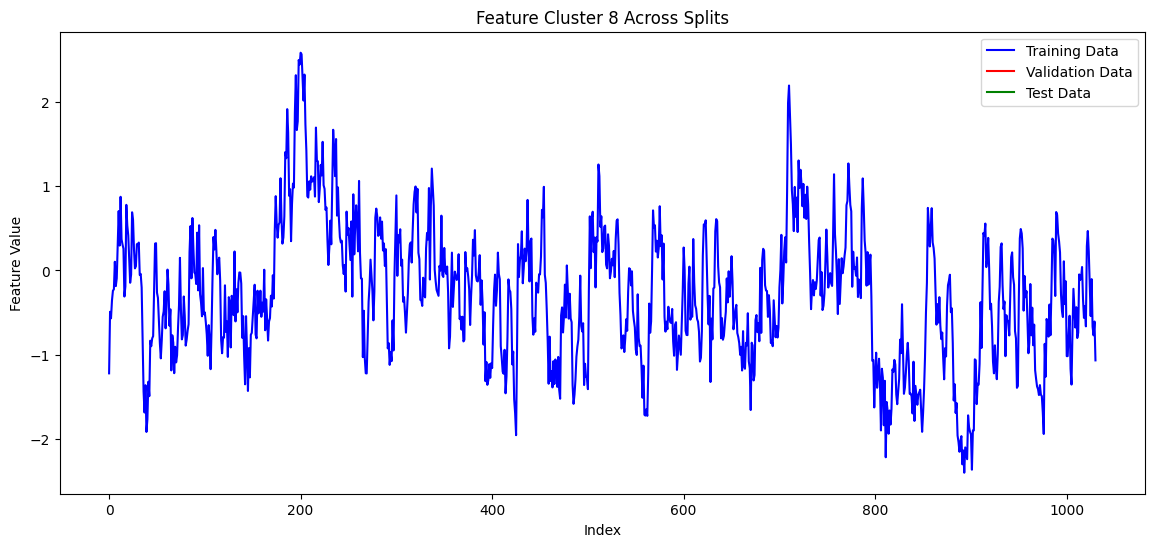

In [656]:
train_set.plot_cluster_split(cluster_index=7)

### Optimizer and criterion

In [657]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [658]:
def print_batches(data_loader):
    for i, (batch_x, batch_y) in enumerate(data_loader):
        print(f"Batch {i+1}")
        print(f"Input (batch_x): \n{batch_x.shape}")
        print(f"Output (batch_y): \n{batch_y.shape}")
        # Break after printing the first batch to avoid flooding the output
        break
    
print_batches(data_loader_train)

Batch 1
Input (batch_x): 
torch.Size([10, 50, 2])
Output (batch_y): 
torch.Size([10, 50, 2])


### Exp baseClass

In [659]:

class Exp_Basic(object):
    def __init__(self, args):
        self.args = args
        self.device = self._acquire_device()
        self.model = self._build_model().to(self.device)

    def _build_model(self):
        raise NotImplementedError
        return None
    
    def _acquire_device(self):
        if self.args.use_gpu:
            #os.environ["CUDA_VISIBLE_DEVICES"] = str(self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            device = torch.device('cpu')
            print('Use CPU')
        return device

    def _get_data(self):
        pass

    def vali(self):
        pass

    def train(self):
        pass

    def test(self):
        pass
    

## Exp main class

In [660]:


class Exp_fish(Exp_Basic):
    def __init__(self, model, data_loader_train, data_loader_val, data_loader_test,device,criterion,optimizer,num_epochs):
        self.device = device
        self.model = model
        self.model = self.model.to(self.device)
        
        self.data_loader_train = data_loader_train
        self.data_loader_val = data_loader_val
        self.data_loader_test = data_loader_test
        
        
        self.criterion = criterion
        self.optim = optimizer
        self.num_epochs=num_epochs
        
        self.model_path = "crossModel"
        os.makedirs(self.model_path, exist_ok=True)
        
        
    def vali(self,vali_loader):
        self.model.eval()
        total_loss = []
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(vali_loader):
                pred, true = self._process_one_batch(batch_x, batch_y)
                loss = self.criterion(pred.detach().cpu(), true.detach().cpu())
                total_loss.append(loss.detach().item())
        total_loss = np.average(total_loss)
        self.model.train()
        return total_loss

    def train(self):
        train_loader = self.data_loader_train
        vali_loader = self.data_loader_val
        test_loader = self.data_loader_test

        train_steps = len(train_loader)
        model_optim = self.optim
        criterion = self.criterion

        for epoch in range(self.num_epochs):
            iter_count = 0
            train_loss = []
            self.model.train()
            for block in self.model.encoder.encode_blocks:
                for layer in block.encode_layers:
                    layer.reset_attention_across_channels_details()
                    
                    
            epoch_time = time.time()
            for i, (batch_x, batch_y) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                pred, true = self._process_one_batch(batch_x, batch_y)
                loss = criterion(pred, true)
                train_loss.append(loss.item())
                if (i + 1) % 100 == 0:
                    print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                loss.backward()
                model_optim.step()
            print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
            train_loss = np.average(train_loss)
            #vali_loss = self.vali(vali_loader)
            vali_loss = 0
            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss))
            
        torch.save(self.model.state_dict(), os.path.join(self.model_path, 'best_model.pth'))
        best_model_path = os.path.join(self.model_path, 'best_model.pth')
        self.model.load_state_dict(torch.load(best_model_path))
        return self.model

    def test(self, setting, save_pred=False ):
        test_loader = self.data_loader_val
        self.model.eval()
        preds = []
        trues = []
        metrics_all = []
        instance_num = 0
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(test_loader):
                pred, true = self._process_one_batch(batch_x, batch_y)
                batch_size = pred.shape[0]
                instance_num += batch_size
                batch_metric = np.array(metric(pred.detach().cpu().numpy(), true.detach().cpu().numpy())) * batch_size
                metrics_all.append(batch_metric)
                if save_pred:
                    preds.append(pred.detach().cpu().numpy())
                    trues.append(true.detach().cpu().numpy())
                break
                
        metrics_all = np.stack(metrics_all, axis=0)
        metrics_mean = metrics_all.sum(axis=0) / instance_num
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mae, mse, rmse, mape, mspe = metrics_mean
        print('mse:{}, mae:{}'.format(mse, mae))
        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        if save_pred:
            preds = np.concatenate(preds, axis=0)
            trues = np.concatenate(trues, axis=0)
            np.save(folder_path + 'pred.npy', preds)
            np.save(folder_path + 'true.npy', trues)
        return

    def _process_one_batch(self, batch_x, batch_y):
        batch_x = batch_x.float().to(self.device)
        batch_y = batch_y.float().to(self.device)
        outputs = self.model(batch_x)
        return outputs, batch_y

    def eval(self, setting, save_pred=False):
        test_loader = self.data_loader_val
        self.model.eval()
        preds = []
        trues = []
        metrics_all = []
        instance_num = 0
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(test_loader):
                pred, true = self._process_one_batch(batch_x, batch_y)
                batch_size = pred.shape[0]
                instance_num += batch_size
                batch_metric = np.array(metric(pred.detach().cpu().numpy(), true.detach().cpu().numpy())) * batch_size
                metrics_all.append(batch_metric)
                
                if save_pred:
                    preds.append(pred.detach().cpu().numpy())
                    trues.append(true.detach().cpu().numpy())
                    
                break
            
        metrics_all = np.stack(metrics_all, axis=0)
        metrics_mean = metrics_all.sum(axis=0) / instance_num
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mae, mse, rmse, mape, mspe = metrics_mean
        print('mse:{}, mae:{}'.format(mse, mae))
        np.save(folder_path + 'metrics.npy', np.array([mae, mse, rmse, mape, mspe]))
        if save_pred:
            preds = np.concatenate(preds, axis=0)
            trues = np.concatenate(trues, axis=0)
            np.save(folder_path + 'pred.npy', preds)
            np.save(folder_path + 'true.npy', trues)

## Training 

In [606]:
exp = Exp_fish(model=model,
               data_loader_train=data_loader_train,
               data_loader_test=None,
               data_loader_val=None,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE
               
               )

model = exp.train()


Epoch: 1 cost time: 5.399342060089111
Epoch: 1, Steps: 76 | Train Loss: 0.0946344 Vali Loss: 0.0000000
Epoch: 2 cost time: 4.89807653427124
Epoch: 2, Steps: 76 | Train Loss: 0.0635752 Vali Loss: 0.0000000


## Analysis

In [607]:


tsa_layer = model.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights = tsa_layer.get_attn()
tsa_layer_weights[0]['att-A-B'].shape


torch.Size([10, 1, 4, 4])

In [608]:
decoder = model.decoder.decode_layers[0]
decoder_layer_weights = decoder.get_attn()

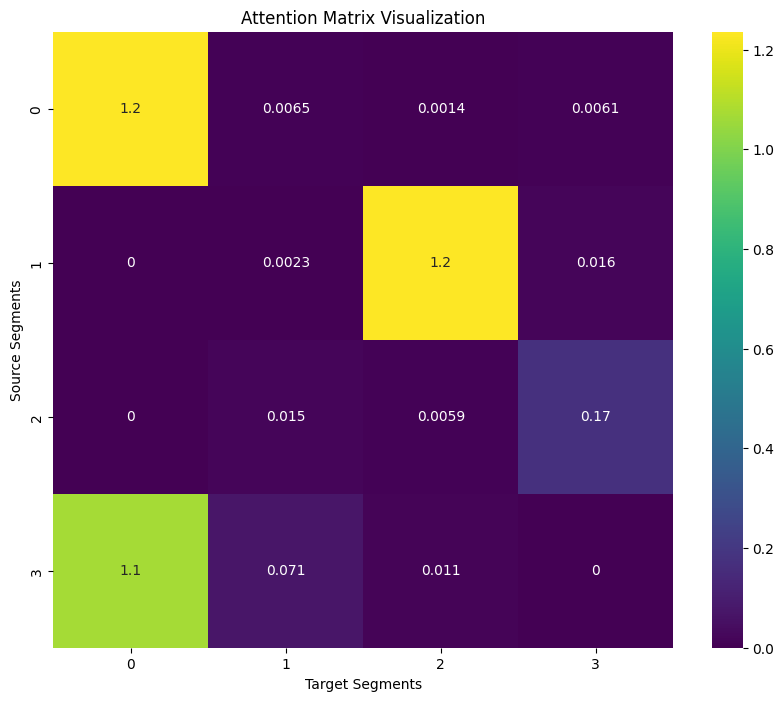

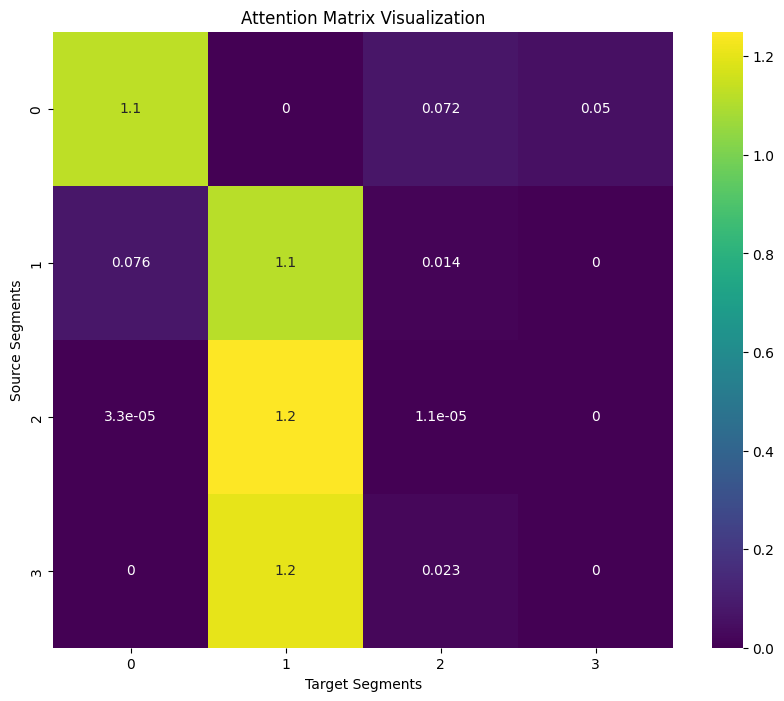

In [609]:

attention_matrix_rec = tsa_layer_weights[0]['att-A-B'][0, 0, :, :].cpu().numpy()
attention_matrix_send= tsa_layer_weights[0]['att-B-A'][0, 0, :, :].cpu().numpy()

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix_rec, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix_send, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()




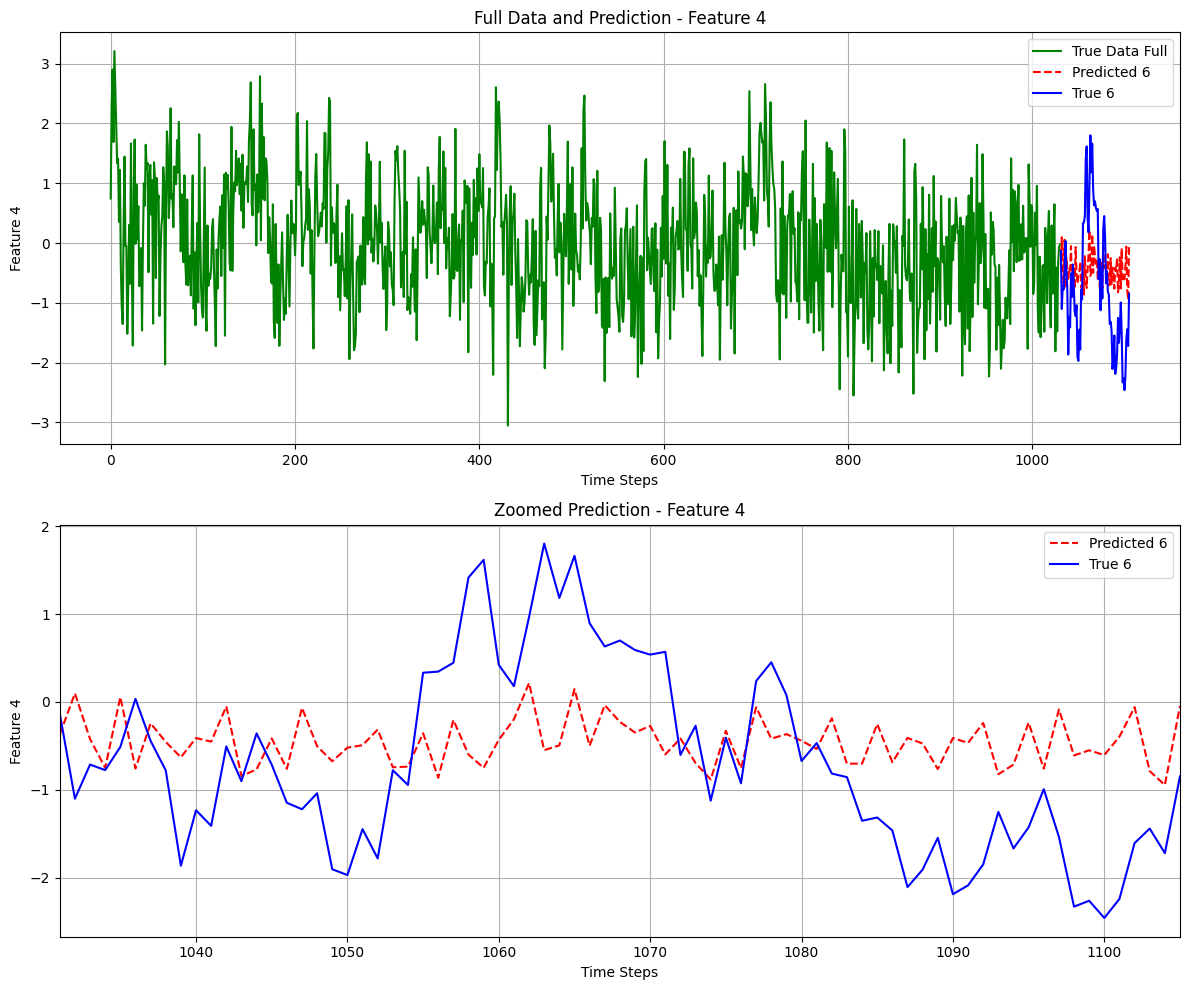

In [610]:

def plot_results(setting, feature_index):
    folder_path = './results/' + setting + '/'
    scaler = StandardScaler()
    all_cluster_true =train_set.get_raw_data_before_split()
    cluster_index = 5
    true_data_full = np.reshape(all_cluster_true.iloc[:,cluster_index].values,(len(all_cluster_true.iloc[:,cluster_index]),1))
    true_data_full = scaler.fit_transform(true_data_full)
    # Load the saved predictions and true values
    preds = np.load(folder_path + 'pred.npy')
    trues = np.load(folder_path + 'true.npy')
    
    # Select the desired feature
    preds_feature = preds[:, :, feature_index]
    trues_feature = trues[:, :, feature_index]
    
    # Create an array of time steps
    time_steps_full = np.arange(len(true_data_full))
    prediction_start = int(len(true_data_full) * DATA_SPLIT[0])
    time_steps_preds = np.arange(prediction_start, prediction_start + preds_feature.shape[1])    
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
     # Plot the full data on the first subplot
    ax1.plot(time_steps_full, true_data_full.flatten(), label='True Data Full',color="green")
    ax1.plot(time_steps_preds, preds_feature[cluster_index], '--', label=f'Predicted {cluster_index+1}',color="red")
    ax1.plot(time_steps_preds, trues_feature[cluster_index], label=f'True {cluster_index+1}',color="blue")
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel(f'Feature {feature_index+1}')
    ax1.legend()
    ax1.set_title(f'Full Data and Prediction - Feature {feature_index+1}')
    ax1.grid(True)
    
    # Zoom in on the prediction part on the second subplot
    ax2.plot(time_steps_preds, preds_feature[cluster_index], '--', label=f'Predicted {cluster_index+1}',color="red")
    ax2.plot(time_steps_preds, trues_feature[cluster_index], label=f'True {cluster_index+1}',color="blue")
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel(f'Feature {feature_index+1}')
    ax2.legend()
    ax2.set_title(f'Zoomed Prediction - Feature {feature_index+1}')
    ax2.grid(True)
    
    # Optionally set a tighter x-axis limit for the zoomed plot
    ax2.set_xlim([prediction_start, time_steps_preds[-1]])
    
    plt.tight_layout()
    plt.show()





plot_results("test",feature_index=3)


In [611]:
folder_path = './results/' + "test" + '/'
# Load the saved predictions and true values
preds = np.load(folder_path + 'pred.npy')
trues = np.load(folder_path + 'true.npy')

# Select the desired feature
preds_feature = preds[:, :, 0]
trues_feature = trues[:, :, 0]


# Experiment synthetic data



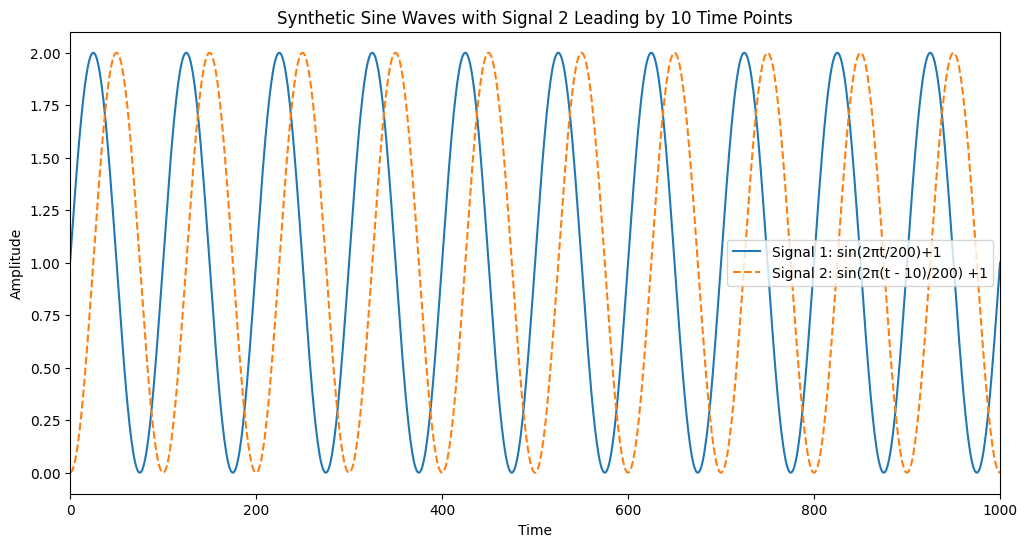

In [612]:
# Generate synthetic data with adjustments
t = np.linspace(0, 1000, 1000)  # Time variable from 0 to 1000
signal_1 = np.sin(2 * np.pi * t / 100) +1  # First sine wave
signal_2 = np.sin(2 * np.pi * (t - 25) / 100) +1 # Second sine wave, shifted to be ahead by 10 time points

# Plot the adjusted synthetic signals
plt.figure(figsize=(12, 6))
plt.plot(t, signal_1, label='Signal 1: sin(2πt/200)+1')
plt.plot(t, signal_2, label='Signal 2: sin(2π(t - 10)/200) +1', linestyle='--')
plt.legend()
plt.title('Synthetic Sine Waves with Signal 2 Leading by 10 Time Points')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)  # Limiting x-axis to show the leading effect more clearly
plt.show()



In [674]:
import pandas as pd

# Creating a pandas DataFrame to store the synthetic data
df = pd.DataFrame({
    'Signal_1': signal_1,
    'Signal_2': signal_1
})

# Display the first few rows of the DataFrame
df.head()
len(df)





1000

In [683]:
#DATASET 
ROOT_PATH = "Data/fishes/fish02/s1/"
DATA_PATH = "df_timeseries_red_clusters_s1.csv"
TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[100,100,100] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
#DATALOADER 
BATCH_SIZE = 10
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 2 # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 20
WIN_SIZE = 1
FACTOR   = 2
D_MODEL  = 256 
D_FF     = 512
N_HEADS  = 1
E_LAYERS = 1
DROPOUT  = 0.2
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#OPTIMIZER
LR = 0.0001

#TRAINING 
NUM_EPOCHS = 5


In [684]:
synth_data = Dataset_MTS_simplified(df_data=df,stride=1,size=SIZE,cols_target=[0,1])
data_loader_train_synth = DataLoader(
            synth_data,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )



In [685]:
model_synt = Crossformer(
    data_dim=DATA_DIM,
    in_len=IN_LEN,
    out_len=OUT_LEN,
    seg_len=SEG_LEN,
    win_size=WIN_SIZE,
    factor=FACTOR,
    d_model=D_MODEL,
    d_ff=D_MODEL,
    n_heads=N_HEADS,
    e_layers=E_LAYERS,
    dropout=DROPOUT,
    baseline=False,
    device=DEVICE
    
).float()

criterion = nn.MSELoss()
optimizer = optim.Adam(model_synt.parameters(), lr=LR)

## Train

In [686]:
exp = Exp_fish(model=model_synt,
               data_loader_train=data_loader_train_synth,
               data_loader_test=None,
               data_loader_val=None,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE
               
               )

model = exp.train()







	iters: 100, epoch: 1 | loss: 0.1044698
Epoch: 1 cost time: 7.524204254150391
Epoch: 1, Steps: 100 | Train Loss: 0.4296809 Vali Loss: 0.0000000
	iters: 100, epoch: 2 | loss: 0.0522719
Epoch: 2 cost time: 6.827437162399292
Epoch: 2, Steps: 100 | Train Loss: 0.0870976 Vali Loss: 0.0000000
	iters: 100, epoch: 3 | loss: 0.0361864
Epoch: 3 cost time: 7.236072778701782
Epoch: 3, Steps: 100 | Train Loss: 0.0741444 Vali Loss: 0.0000000
	iters: 100, epoch: 4 | loss: 0.0503481
Epoch: 4 cost time: 7.271038293838501
Epoch: 4, Steps: 100 | Train Loss: 0.0628827 Vali Loss: 0.0000000
	iters: 100, epoch: 5 | loss: 0.0393252
Epoch: 5 cost time: 7.469303369522095
Epoch: 5, Steps: 100 | Train Loss: 0.0625108 Vali Loss: 0.0000000


## Weights

In [705]:
tsa_layer = model.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights = tsa_layer.get_attn()
tsa_layer_weights[1]['att-A-B'].shape
len(tsa_layer_weights)
tsa_l = model.decoder.decode_layers[0]
dec_attn=tsa_l.get_attn()
dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
dec_attn[0]['dec_attnetion'].shape



torch.Size([20, 1, 5, 5])

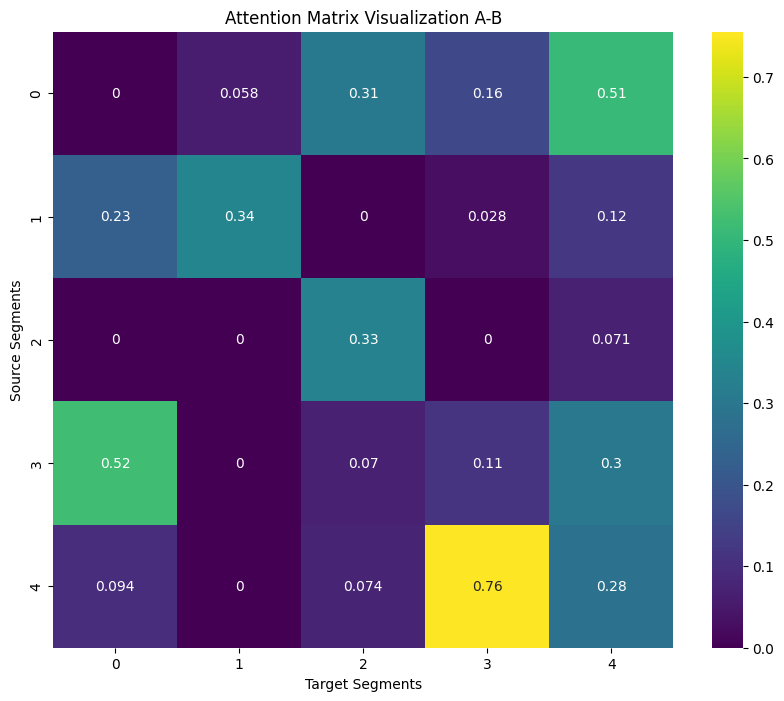

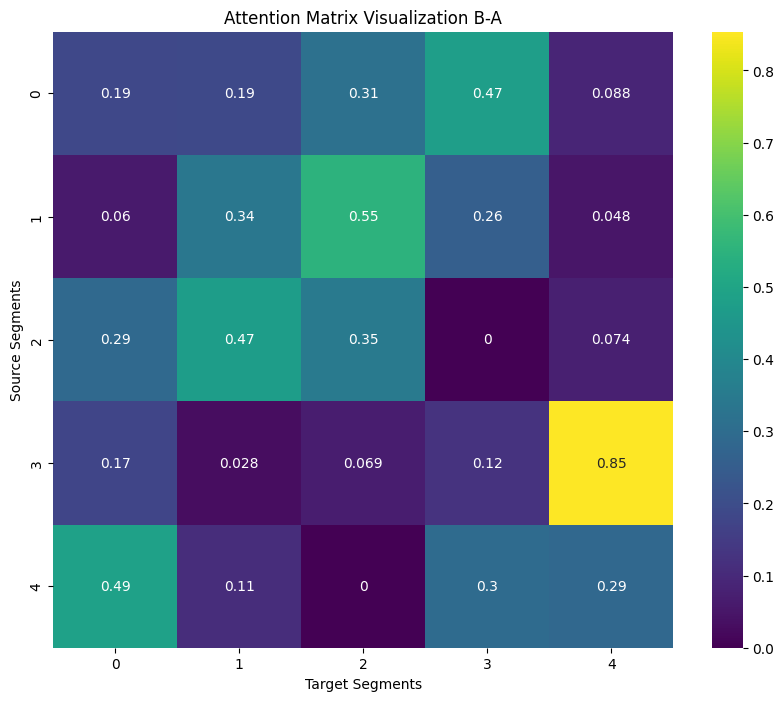

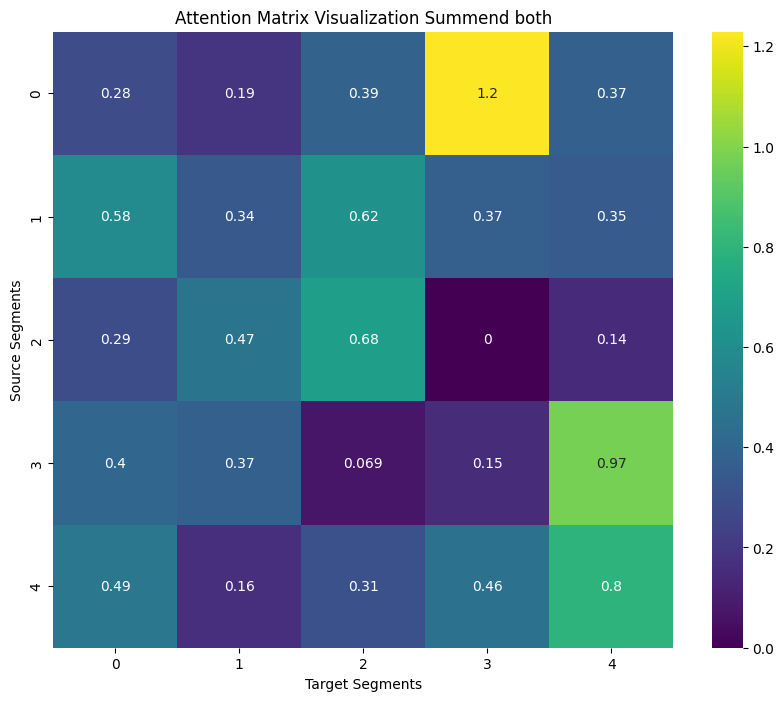

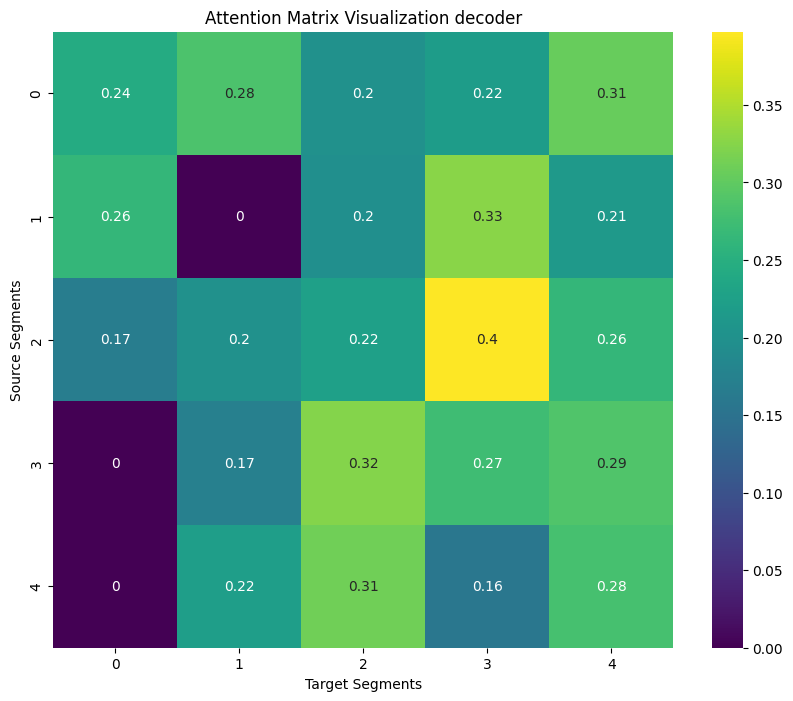

In [706]:
attention_matrix_rec = tsa_layer_weights[0]['att-A-B'][0, 0, :, :].cpu().numpy()
attention_matrix_send= tsa_layer_weights[0]['att-B-A'][0, 0, :, :].cpu().numpy()
att_plus_both = attention_matrix_rec + np.flipud(attention_matrix_send)
dec_attn = dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix_send, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization A-B')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix_rec, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization B-A')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(att_plus_both, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization Summend both')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(dec_attn, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization decoder')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()

In [689]:

model.eval()
total_loss = 0
count = 0
preds =[]
with torch.no_grad():  # Disable gradient computation for evaluation
    for batch_idx, (inputs, targets) in enumerate(data_loader_train_synth):
        # Assuming your model and data are on the same device (CPU or GPU), otherwise you'll need to move them to the same device.
        predictions = model(inputs.float())  # Get model predictions
        
        predictions  = (predictions).numpy()
        
        preds.append(predictions)
# Example plot for the first signal in the batch


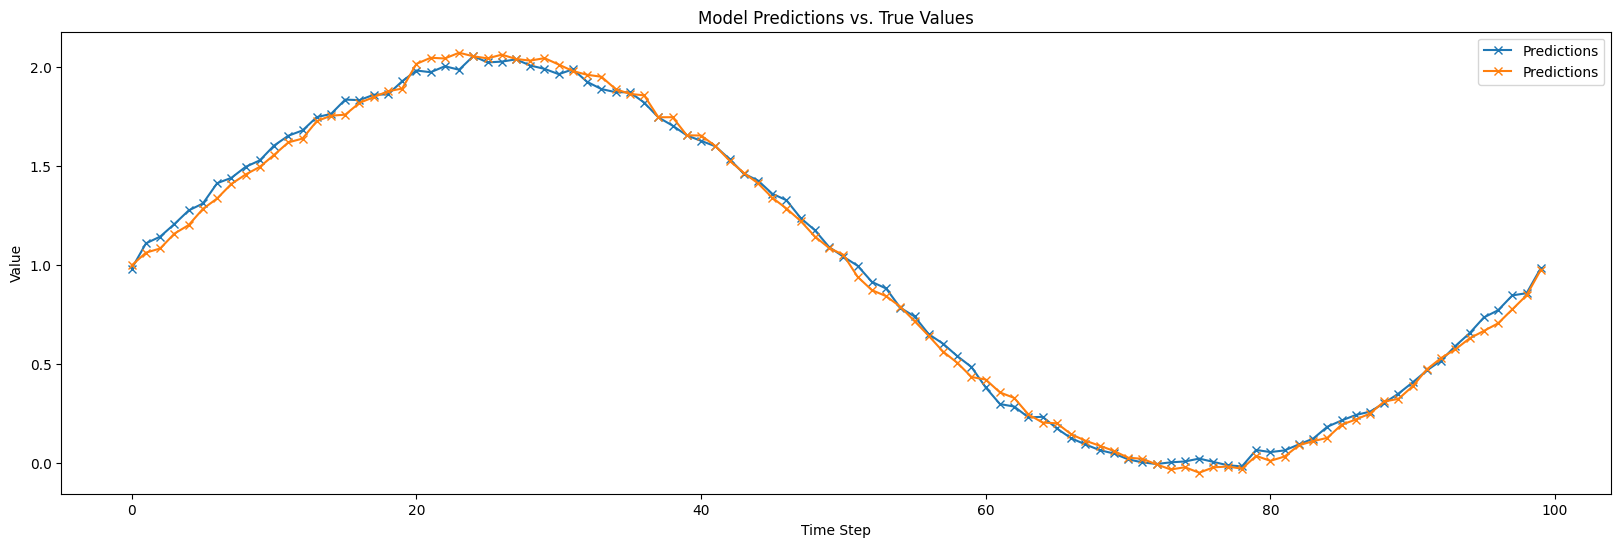

In [690]:
plt.figure(figsize=(20, 6))
plt.plot(preds[0][0], label='Predictions', marker='x')  # Adjust indexing based on your data shape
plt.legend()
plt.title('Model Predictions vs. True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()


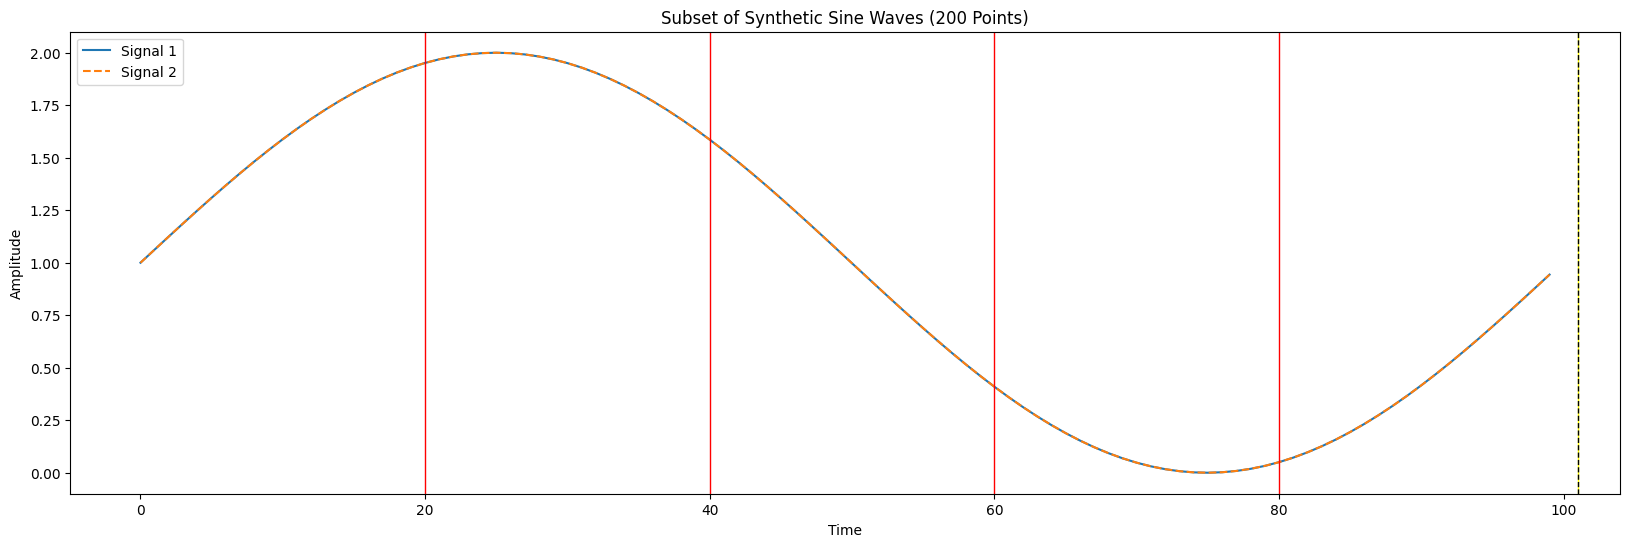

,Signal_1,Signal_2
0,1.000000,1.000000
1,1.062853,1.062853
2,1.125458,1.125458
3,1.187567,1.187567
4,1.248934,1.248934
...,...,...
195,0.702670,0.702670
196,0.763269,0.763269
197,0.824804,0.824804
198,0.887031,0.887031


In [695]:
# Load 200 points for each of the signals from the DataFrame
df_subset = df.iloc[:100]

# Plot the subset of data for both signals
plt.figure(figsize=(20, 6))
plt.plot( df_subset['Signal_1'], label='Signal 1')
plt.plot( df_subset['Signal_2'], label='Signal 2', linestyle='--')
for x in range(20, 100, 20):
    plt.axvline(x=x, color='red', linestyle='-', linewidth=1)
 
plt.axvline(x=101, color='yellow', linestyle='-', linewidth=1)   
plt.axvline(x=101, color='black', linestyle='--', linewidth=1)   

plt.legend()
plt.title('Subset of Synthetic Sine Waves (200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
df.iloc[:200]